# Functions and implementation

In [75]:
import string
import re

import matplotlib.pyplot as plt

from collections import Counter, OrderedDict

import numpy as np
import pandas as pd 

from nltk.tokenize import WordPunctTokenizer
from nltk.tokenize import WhitespaceTokenizer
from nltk.stem.snowball import SnowballStemmer

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_selection import SelectKBest, chi2

from sklearn.metrics import precision_score, recall_score, accuracy_score



## Summary of the process 

* Receive all documents (i.e. texts) as a `List`, `DataFrame` or `Series`.  


* Define function to clean a string:
 * ```python
     def clean(doc, regex_list=[("<[^>]*>", "")] ):
        
        # remove or replace characters
        for regex in regex_list:
            doc = re.sub(regex[0], regex[1], doc)
        # lowercase
        doc = doc.lower()
        # tokenize
        words = tokenizer.tokenize(doc)
        # remove punctuation
        words = list(filter(lambda x: x not in string.punctuation, words))
        # stem
        stems = list(map(stemmer.stem, words))
        new_doc = " ".join(stems)
        return new_doc
   ```  


* Appy `df.applymap(clean)` or `series.apply(clean)` or List comprehension.   


* Define a function to build the set of distinct words (i.e., the vocabulary) occurring in `docs` (see `Counter()` and `OrderedDict()` in [library collections](https://docs.python.org/2/library/collections.html)):
 * ```python
     def build_vocabulary(docs):
        vocabulary = Counter()

        for doc in docs:
            words = doc.split()
            vocabulary.update(words)

        return OrderedDict(vocabulary.most_common())
 ```


* Define a function to vectorize the documents, i.e., convert documents into a table where each line represents one document and the columns are the word counts.  
 * ```python
     def vectorize(docs):
        vocabulary = build_vocabulary()
        vectors = []
        for doc in docs:
            vector = np.array([doc.count(word) for word in vocabulary])
            vectors.append(vector)

        return vectors
 ```

* `docs_BOW = pd.DataFrame(vectorize(), columns=build_vocabulary())`  


* Improvements to the bag of words representation:
 * Remove *stop words*
 * Term Frequency - Inverse Document Frequency (TF-IDF)
 * nest

**Or...**

* use fsadf

## Alternatives

* Instead of a `clean()` function define a sklearn `Class` with the clean function inside so we can call a `transform()` method to apply the cleaning to each document. In this way we can include this step in a Pipeline.  


* Use sklearn [CountVectorizer()](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html) instead of `build_vocabulary()` + `vectorize()`.  
It receives an iterable of documents and returns a vectorized sparse matrix of token counts of those documents.  


* Use sklearn [TfidfTransformer()](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html) to transform a count matrix to a normalized tf or tf-idf representation.  
`CountVectorizer()` followed by `TfidfTransformer()` is equivalent to [TfidfVectorizer()](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html).  


* next

# Implementation

In [16]:
df = pd.read_csv('./BLU07 - Feature Extraction/data/imdb_sentiment.csv')
df.head()

,sentiment,text
0,Negative,"Aldolpho (Steve Buscemi), an aspiring film mak..."
1,Negative,"An unfunny, unworthy picture which is an undes..."
2,Negative,A failure. The movie was just not good. It has...
3,Positive,I saw this movie Sunday afternoon. I absolutel...
4,Negative,Disney goes to the well one too many times as ...


In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 2 columns):
sentiment    5000 non-null object
text         5000 non-null object
dtypes: object(2)
memory usage: 78.2+ KB


## Cleaning function

In [29]:
def clean(doc,
          regex_list = [("<[^>]*>", "")], 
          tokenizer = WordPunctTokenizer(),
          stemmer = SnowballStemmer("english", ignore_stopwords=False)):
    
        
    # Replace given regexes
    for regex in regex_list:
        doc = re.sub(regex[0], regex[1], doc)
    
    # lowercase
    doc = doc.lower()
    
    # tokenize
    words = tokenizer.tokenize(doc)
    
    # remove punctuation
    words = list(filter(lambda x: x not in string.punctuation, words))
    
    # stem
    stems = list(map(stemmer.stem, words))
    
    new_doc = " ".join(stems)
    
    return new_doc


In [39]:
df.text[2]

"A failure. The movie was just not good. It has humor that 5 year olds that will not even giggle at. I mean, sure, some parts were amusing, but most of it is not. Lindsey Lohan is a great actress (and a bad singer,) and she should be working on better movies. The movie should have been aired as a Disney Channel original movie, that is FREE.<br /><br />The only thing that was well done about this movie was the music. Nothing like a remade rock soundtrack to brighten up your day. These songs are so good. Especially Alyson and Amanda's Walking On Sunshine and Caleigh Peter's, Beach Boy song, Fun Fun Fun.<br /><br />4 out of 10. If I gave it a ten, 9 of that would be the music and 1 will be the movie. Not worth your money, but the soundtrack is."

In [46]:
df.text[[2]].apply(clean)[2]

'a failur the movi was just not good it has humor that 5 year old that will not even giggl at i mean sure some part were amus but most of it is not lindsey lohan is a great actress and a bad singer ,) and she should be work on better movi the movi should have been air as a disney channel origin movi that is free the only thing that was well done about this movi was the music noth like a remad rock soundtrack to brighten up your day these song are so good especi alyson and amanda s walk on sunshin and caleigh peter s beach boy song fun fun fun 4 out of 10 if i gave it a ten 9 of that would be the music and 1 will be the movi not worth your money but the soundtrack is'

In [50]:
clean_args = ([("<[^>]*>", "")], 
        WhitespaceTokenizer(),
        SnowballStemmer("english"))

df.text[[2]].apply(clean, args=clean_args)[2]

"a failure. the movi was just not good. it has humor that 5 year old that will not even giggl at. i mean, sure, some part were amusing, but most of it is not. lindsey lohan is a great actress (and a bad singer,) and she should be work on better movies. the movi should have been air as a disney channel origin movie, that is free.th onli thing that was well done about this movi was the music. noth like a remad rock soundtrack to brighten up your day. these song are so good. especi alyson and amanda walk on sunshin and caleigh peter's, beach boy song, fun fun fun.4 out of 10. if i gave it a ten, 9 of that would be the music and 1 will be the movie. not worth your money, but the soundtrack is."

## NLP predictor

In [63]:
def NLP_get_predictions(X_train, y_train, X_test, y_test,
                        vectorizer = TfidfVectorizer(ngram_range=(1,1), stop_words=None),
                        clf = MultinomialNB()):
    '''Returns a fitted TfidfVectorizer and the test precision and recall on the 'spam' class
       from a KNeighborsClassifier trained on the inputted train data
    
    Parameters:
        X_train (Series): Text data for training
        y_train (Series): Labels corresponding to X_train
        X_test (Series): Text data for testing
        y_test (Series): Labels corresponding to X_test

    Returns:
        vectorizer (TfidfVectorizer): TfidfVectorizer with max_features == 50, fitted to X_train
        precision (float): The precision score of the spam class on the test data from a
                           KNeighborsClassifier fitted to the vectorized training data
        recall (float): The recall score of the spam class on the test data from a
                        KNeighborsClassifier fitted to the vectorized training data
    '''
    
    # Fit the vectorizer to the train data    
    vectorizer.fit(X_train)
    
    X_train_vect = vectorizer.transform(X_train)
    X_test_vect = vectorizer.transform(X_test)
    
    y_train = y_train.values
    y_test = y_test.values
    
    
    # Fit the classifier to the train data
    clf.fit(X_train_vect, y_train)

    y_pred = clf.predict(X_test_vect)
    
    # Performance assessment
    accuracy = np.mean(y_pred == y_test)    
    #precision = precision_score(vect_y_test=='spam', pred=='spam')
    #recall = recall_score(vect_y_test=='spam', pred=='spam')
        
    return y_pred, vectorizer, clf

In [64]:
X_train, X_test, y_train, y_test = train_test_split(df['text'].apply(clean), df['sentiment'], test_size=0.3, random_state=42)

In [65]:
y_pred, vectorizer, classifier = NLP_get_predictions(X_train, y_train, X_test, y_test)

In [67]:
accuracy = np.mean(y_pred == y_test)
accuracy

0.8546666666666667

## Feature Selction

### Using scikit-learn [chi2](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.chi2.html)

In [71]:
X_train_vect = vectorizer.transform(X_train)
chi_values, p_values = chi2(X_train_vect, y_train)

print("X_train_vect type: {}".format(type(X_train_vect)))
print("X_train_vect.shape: {}".format(X_train_vect.shape))
print("\nchi_values type: {}".format(type(chi_values)))
print("chi_values shape: {}".format(chi_values.shape))

X_train_vect type: <class 'scipy.sparse.csr.csr_matrix'>
X_train_vect.shape: (3500, 22668)

chi_values type: <class 'numpy.ndarray'>
chi_values shape: (22668,)


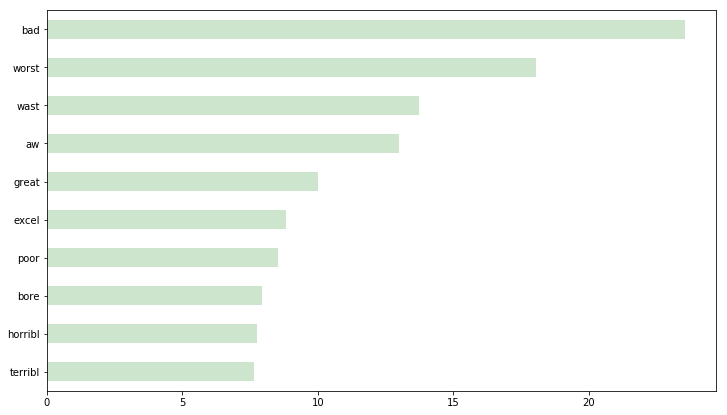

In [80]:
feature_names = vectorizer.get_feature_names()

feature_chi_series = pd.Series(chi_values, index=feature_names)

feature_chi_series.sort_values(ascending=True)[-10:].plot.barh(figsize=(12,7), align='center', alpha=.2, color='g')
plt.show()

### Using scikit-learn [SelectKBest](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectKBest.html)

In [81]:
X_train_vect = vectorizer.transform(X_train)

ch2_selector = SelectKBest(chi2, k=10)
ch2_selector.fit(X_train_vect, y_train)

X_train_vect_new = ch2_selector.transform(X_train_vect)

In [82]:
X_train_vect_new

<3500x10 sparse matrix of type '<class 'numpy.float64'>'
	with 3796 stored elements in Compressed Sparse Row format>

In [97]:
np.array(vectorizer.get_feature_names())[ch2_selector.get_support()]

array(['aw', 'bad', 'bore', 'excel', 'great', 'horribl', 'poor',
       'terribl', 'wast', 'worst'], dtype='<U25')